In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33833")
client

<Client: 'tcp://127.0.0.1:33833' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:35245' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()

fio01grid = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/grid.zarr"))

In [6]:
fio01w = cat["FIO-COM32"](region='1',datatype='interior_daily', season='fma'
                         ).to_dask().chunk({'yt_ocean':100,'xt_ocean':100})
fio01w

<xarray.Dataset>
Dimensions:        (bnds: 2, st_ocean: 57, sw_ocean: 57, time: 89, xt_ocean: 320, xu_ocean: 321, yt_ocean: 320, yu_ocean: 321)
Coordinates:
  * st_ocean       (st_ocean) float64 1.0 3.196 5.96 ... 6.117e+03 6.684e+03
  * sw_ocean       (sw_ocean) float64 2.098 4.578 7.784 ... 6.4e+03 7e+03
  * time           (time) datetime64[ns] 2018-02-02T12:00:00 ... 2018-04-30T1...
  * xt_ocean       (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.05 -68.02
  * xu_ocean       (xu_ocean) float64 -78.0 -77.97 -77.94 ... -68.03 -68.0
  * yt_ocean       (yt_ocean) float64 30.02 30.05 30.08 ... 39.92 39.95 39.98
  * yu_ocean       (yu_ocean) float64 30.0 30.03 30.06 ... 39.94 39.97 40.0
Dimensions without coordinates: bnds
Data variables:
    salt           (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 57, 100, 100), meta=np.ndarray>
    st_ocean_bnds  (st_ocean, bnds) float64 dask.array<chunksize=(57, 2), meta=np.ndarray>
    sw_ocean_bnds  (sw_ocean, bnds) float64 dask.array<chunksize=(57, 2), meta=np.ndarray>
    temp           (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 57, 100, 100), meta=np.ndarray>
    u              (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(5, 57, 321, 321), meta=np.ndarray>
    v              (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(5, 57, 321, 321), meta=np.ndarray>
    wt             (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(5, 57, 100, 100), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6

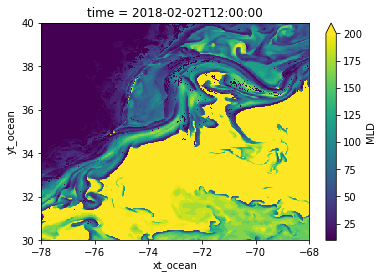

In [7]:
grav = 9.81
w_path = f'{SCRATCH}/region01/FIO-COM32/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0.chunk({'st_ocean':5})

b_win = -xr.DataArray(sig0w.data, dims=fio01w.temp.dims, coords=fio01w.temp.coords) * grav / 1e3


MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/MLD_fma.zarr")
                   ).MLD.chunk({'time':10,'yt_ocean':100,'xt_ocean':100})
MLDw.isel(time=0).plot(vmax=200)

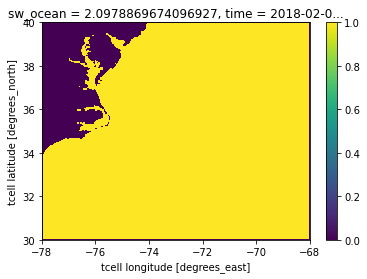

In [8]:
bw = .5*xr.DataArray(b_win.isel(st_ocean=slice(None,-1)).data + b_win.isel(st_ocean=slice(1,None)).data,
                     dims=['time','sw_ocean','yt_ocean','xt_ocean'],
                     coords=fio01w.wt.isel(sw_ocean=slice(None,-1)).coords
                    )

maskb = np.ma.masked_invalid(bw.isel(time=0)).mask
mask = ~np.ma.masked_array(np.ma.masked_invalid(fio01w.wt.isel(time=0,sw_ocean=slice(None,-1))),maskb).mask

wet_mask = xr.DataArray(np.zeros_like(fio01w.wt.isel(time=0,sw_ocean=slice(None,-1))),
                        dims=['sw_ocean','yt_ocean','xt_ocean'],
                        coords=fio01w.wt.isel(time=0,sw_ocean=slice(None,-1)).coords
           )
wet_mask[:,1:-1,1:-1] = mask[:,1:-1,1:-1].astype(np.float64)
wet_mask.isel(sw_ocean=0).plot()

In [11]:
uw = .5*xr.DataArray(fio01w.u.isel(time=0,st_ocean=slice(None,-1)).data 
                     + fio01w.u.isel(time=0,st_ocean=slice(1,None)).data,
                     dims=['sw_ocean','yu_ocean','xu_ocean'],
        )
masku = xr.DataArray(np.ma.masked_invalid(uw).mask,
                     dims=['sw_ocean','yu_ocean','xu_ocean'],
                     coords={'sw_ocean':fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)),
                             'yu_ocean':fio01w.yu_ocean,'xu_ocean':fio01w.xu_ocean}
        )

In [9]:
area = xr.DataArray(fio01grid.DXT * fio01grid.DYT, dims=['yt_ocean','xt_ocean'],
                    coords=fio01w.temp.isel(time=0,st_ocean=0).coords)

In [11]:
dxw = xr.DataArray(.5*(fio01grid.DXC[1:,:-1].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(.5*(fio01grid.DYC[1:,:-1].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(.5*(fio01grid.DXC[:-1,1:].data + fio01grid.DXC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(.5*(fio01grid.DYC[:-1,1:].data + fio01grid.DYC[:-1,:-1].data),
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'mul-8e5e4ae57dbef0e1591b1ae05c268fd0' (yt_ocean: 320, xt_ocean: 320)>
dask.array<mul, shape=(320, 320), dtype=float32, chunksize=(160, 320), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 1.0
    time      datetime64[ns] 2018-02-02T12:00:00
  * xt_ocean  (xt_ocean) float64 -77.98 -77.95 -77.92 ... -68.08 -68.05 -68.02
  * yt_ocean  (yt_ocean) float64 30.02 30.05 30.08 30.11 ... 39.92 39.95 39.98

In [12]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min()
            )
dx_min = dx_min.values
dx_min

array(2663.1006, dtype=float32)

In [13]:
kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)

In [15]:
filter_scale = 30000   # 30 km
filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'dxw': dxw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dyw': dyw.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'dxs': dxs.chunk({'yt_ocean':-1,'xt_ocean':-1}), 'dys': dys.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'area': area.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'kappa_w': kappa_w.chunk({'yt_ocean':-1,'xt_ocean':-1}), 
        'kappa_s': kappa_s.chunk({'yt_ocean':-1,'xt_ocean':-1})
    }
)
filter_30km

Filter(filter_scale=30000, dx_min=array(2663.1006, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=13, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [12]:
Au = xr.DataArray(fio01grid.DXC.data * fio01grid.DYC.data, 
                  dims=['yu_ocean','xu_ocean'],
                  coords=uw.isel(sw_ocean=0).coords
                 )
ncoars = 3

In [12]:
xrdzs = xr.DataArray(np.diff(fio01w.st_ocean.data), dims=['sw_ocean'],
                     coords=fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)).coords
                    )
xrdzs

<xarray.DataArray (sw_ocean: 56)>
array([  2.19577393,   2.76393202,   3.64885899,   4.76393202,
         6.        ,   7.23606798,   8.35114101,   9.23606798,
         9.80422607,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  11.12281967,  14.47715857,
        20.02083395,  27.68413087,  37.37067893,  48.95866416,
        62.30236092,  77.23396449,  93.56570129, 111.09219025,
       129.59302561, 148.83554862, 168.57777339, 188.57143   ,
       208.56508661, 228.30731138, 247.54983439, 266.05066975,
       283.57715871, 299.90889551, 314.84049908, 328.18419584,
       339.77218107, 349.45872913, 357.12202605, 362.66570143,
       366.02004033, 367.14286   , 433.57143   , 566.42857   ])
Coordinates:
  * sw_ocean  (sw_ocean) float64 2.098 4.578 7.784 ... 5.5e+03 5.9e+03 6.4e+03

In [19]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

DYC = xr.DataArray(fio01grid.DYC.data, dims=['yu_ocean','xu_ocean'],
                   coords=fio01w.u.isel(time=0,st_ocean=0).coords
                  )
DXC = xr.DataArray(fio01grid.DXC.data, dims=['yu_ocean','xu_ocean'],
                   coords=fio01w.u.isel(time=0,st_ocean=0).coords
                  )

In [57]:
bm = filter_30km.apply(bw.chunk({'sw_ocean':10,'yt_ocean':-1,'xt_ocean':-1}), 
                       dims=['yt_ocean','xt_ocean']
                      ).chunk({'yt_ocean':100,'xt_ocean':100})

bmx = .5*(bm[...,1:].data + bm[...,:-1].data)
bmy = .5*(bm[...,1:,:].data + bm[...,:-1,:].data)

dbmy = xr.DataArray(diff(bmx, 1, -2)[...,1:,:], 
                    dims=['time','sw_ocean','yu_ocean','xu_ocean'],
                    coords={'time':fio01w.time,
                            'sw_ocean':fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)),
                            'yu_ocean':fio01w.yu_ocean.isel(yu_ocean=slice(1,-1)),
                            'xu_ocean':fio01w.xu_ocean.isel(xu_ocean=slice(1,-1))}
                   ) / DYC[1:-1,1:-1]
dbmx = xr.DataArray(diff(bmy, 1, -1)[...,1:], 
                    dims=['time','sw_ocean','yu_ocean','xu_ocean'],
                    coords={'time':fio01w.time,
                            'sw_ocean':fio01w.sw_ocean.isel(sw_ocean=slice(None,-1)),
                            'yu_ocean':fio01w.yu_ocean.isel(yu_ocean=slice(1,-1)),
                            'xu_ocean':fio01w.xu_ocean.isel(xu_ocean=slice(1,-1))}
                   ) / DXC[1:-1,1:-1]

M2 = np.sqrt(dbmx**2 + dbmy**2)

mldw = xr.DataArray(.25*(MLDw.data + np.roll(MLDw.data,1,-1)
                         + np.roll(MLDw.data,1,-2) + np.roll(np.roll(MLDw.data,1,-1),1,-2)
                        )[:,1:,1:],
                    dims=['time','yu_ocean','xu_ocean'],
                    coords={'time':fio01w.time,
                            'yu_ocean':fio01w.yu_ocean.isel(yu_ocean=slice(1,-1)),
                            'xu_ocean':fio01w.xu_ocean.isel(xu_ocean=slice(1,-1))}
                   )
mldw

<xarray.DataArray 'mul-c7f01943fb6e26c0d3ba07e7f943af46' (time: 89, yu_ocean: 319, xu_ocean: 319)>
dask.array<mul, shape=(89, 319, 319), dtype=float64, chunksize=(10, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 2018-02-02T12:00:00 ... 2018-04-30T12:00:00
  * yu_ocean  (yu_ocean) float64 30.03 30.06 30.09 30.12 ... 39.91 39.94 39.97
  * xu_ocean  (xu_ocean) float64 -77.97 -77.94 -77.91 ... -68.09 -68.06 -68.03

In [13]:
mask_coar = masku.isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1)
                      ).isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1)).sel(sw_ocean=1e2, method='nearest'
                           ).reset_coords(drop=True).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars},
                                                             boundary='trim').mean(skipna=True)

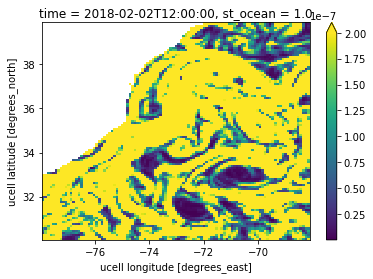

In [65]:
M2_coar = ((M2.where(M2.sw_ocean<=mldw)
            * Au.isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1))
           ).isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1)
                 ).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars}, boundary='trim').sum(skipna=True)
           * Au.isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1)
                    ).isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1)
                          ).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars}, boundary='trim').sum(skipna=True)**-1
          )
    
M2_coarH = (M2_coar 
            * xr.DataArray(xrdzs.where(xrdzs.sw_ocean<=mldw.isel(yu_ocean=slice(1,-1),xu_ocean=slice(1,-1))
                                      ).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars},
                                                boundary='trim'
                                               ).mean(skipna=True).transpose('time','sw_ocean',
                                                                             'yu_ocean','xu_ocean').data,
                           dims=M2_coar.dims, coords=M2_coar.coords)
           ).sum('sw_ocean', skipna=True)

    
import gsw
f = xr.DataArray(gsw.f(fio01w.yu_ocean.isel(yu_ocean=slice(2,-2)).coarsen({'yu_ocean':ncoars},
                                                                          boundary='trim').mean(skipna=True)
                      ).data, 
                 dims='yu_ocean', coords={'yu_ocean':M2_coar.yu_ocean})

    
MLI = (M2_coarH**2 / f).where(mask_coar!=1.)
        
MLI.isel(time=0).plot(vmax=2e-7)
plt.show()

In [67]:
tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'MLI-30km_z0-MLD_fma.zarr' 
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLI.chunk({'time':10,'yu_ocean':100,'xu_ocean':100}).to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/MLI-30km_z0-MLD_fma.zarr


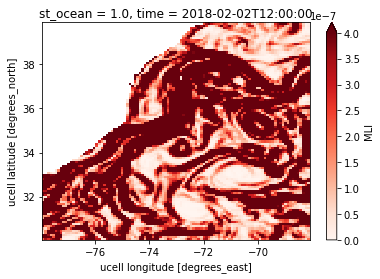

In [14]:
tmp_path = f'{SCRATCH}/region01/FIO-COM32/'+f'MLI-30km_z0-MLD_fma.zarr' 
MLI = xr.open_zarr(gcs.get_mapper(tmp_path)).MLI

MLI.isel(time=0).plot(cmap='Reds', vmin=0, vmax=4e-7)

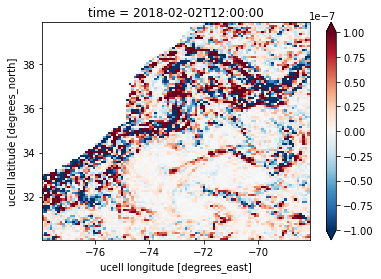

In [15]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/FIO-COM32/wb-30km_z0-MLD_fma.zarr")
                   ).wpbp

wpbp = .25*xr.DataArray((wpbp.data + np.roll(wpbp.data,1,-1)
                         + np.roll(wpbp.data,1,-2) + np.roll(np.roll(wpbp.data,1,-1),1,-2)
                        )[:,1:,1:], dims=['time','yu_ocean','xu_ocean'],
                        coords={'time':fio01w.time,
                                'yu_ocean':fio01w.yu_ocean.isel(yu_ocean=slice(2,-2)),
                                'xu_ocean':fio01w.xu_ocean.isel(xu_ocean=slice(2,-2))}
                       )
wpbp_coar = ((wpbp * Au.isel(yu_ocean=slice(2,-2),xu_ocean=slice(2,-2))
             ).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars}, boundary='trim').sum(skipna=True)
             * Au.isel(yu_ocean=slice(2,-2),xu_ocean=slice(2,-2)
                      ).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars}, boundary='trim').sum(skipna=True)**-1
            ).where(mask_coar!=1.)
wpbp_coar.isel(time=0).plot(cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [16]:
mask0 = masku.isel(yu_ocean=slice(2,-2),xu_ocean=slice(2,-2)
                      ).sel(sw_ocean=0, method='nearest'
                           ).reset_coords(drop=True).coarsen({'yu_ocean':ncoars,'xu_ocean':ncoars},
                                                             boundary='trim'
                                                            ).mean(skipna=True).reset_coords(drop=True)
mask0 = ~np.ma.masked_values(mask0,0).mask
mask0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [17]:
Ce = (wpbp_coar.data / MLI).compute()
Ce.name = 'Ce'

/tmp/ipykernel_3364/1544253756.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(MLI.xu_ocean, MLI.yu_ocean,


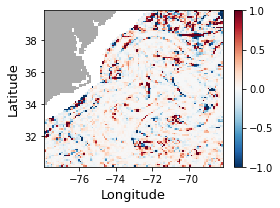

In [41]:
fig, ax = plt.subplots(figsize=(4,3))
fig.set_tight_layout(True)

im = ax.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, Ce.isel(time=0),
                   vmin=-1, vmax=1, cmap='RdBu_r', shading='auto', rasterized=True)

ax.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, 
              np.ma.masked_array(mask0, ~mask0),
              vmin=0, vmax=3, cmap='binary', rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=13)
ax.set_ylabel(r"Latitude", fontsize=13)
fig.colorbar(im, ax=ax)

plt.savefig('/home/jovyan/Figures/FIOCOM32-Ce_01.pdf')

In [18]:
alpha = (Ce).median(['yu_ocean','xu_ocean'],skipna=True)

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar = xr.DataArray(wpbp_coar.data, dims=MLI.dims, coords=MLI.coords)
wpbp_coar.name = 'wpbp'

In [19]:
time = np.arange('2018-02', '2018-05', dtype='datetime64[D]')
time

array(['2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
       '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
       '2018-02-09', '2018-02-10', '2018-02-11', '2018-02-12',
       '2018-02-13', '2018-02-14', '2018-02-15', '2018-02-16',
       '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20',
       '2018-02-21', '2018-02-22', '2018-02-23', '2018-02-24',
       '2018-02-25', '2018-02-26', '2018-02-27', '2018-02-28',
       '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04',
       '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
       '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
       '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16',
       '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20',
       '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24',
       '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28',
       '2018-03-29', '2018-03-30', '2018-03-31', '2018-04-01',
       '2018-04-02', '2018-04-03', '2018-04-04', '2018-

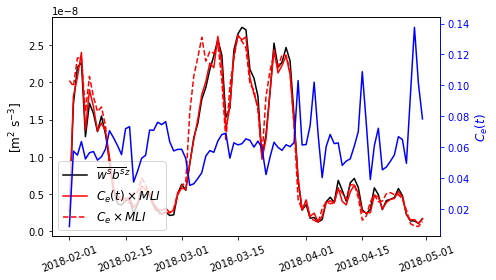

In [25]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['yu_ocean','xu_ocean'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['yu_ocean','xu_ocean'],skipna=True), c='r', label=r'$C_e(t) \times MLI$')
ax.plot(time, (alpha.mean('time')*MLI).median(['yu_ocean','xu_ocean'],skipna=True), c='r', ls='--', label=r'$C_e \times MLI$')

ax2.plot(time, alpha, c='b')

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2018-02-01','2018-02-15','2018-03-01','2018-03-15','2018-04-01','2018-04-15','2018-05-01'])
ax.set_xticklabels(labels=['2018-02-01','2018-02-15','2018-03-01','2018-03-15','2018-04-01','2018-04-15','2018-05-01'],
                   rotation=20)
ax2.set_ylabel(r"$C_e(t)$", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/FIOCOM32-wb-timeseries_01.pdf')

/tmp/ipykernel_8662/3115980255.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, wpbp_coar.isel(time=0),
/tmp/ipykernel_8662/3115980255.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, aMLI.isel(time=0),
/tmp/ipykernel_8662/3115980255.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eith

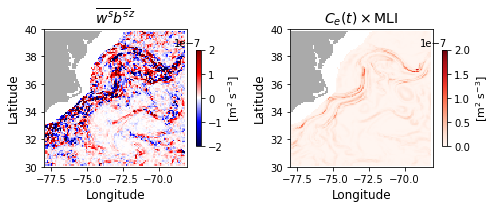

In [24]:
fig, (ax1,ax2) = plt.subplots(figsize=(7,3),nrows=1,ncols=2)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, wpbp_coar.isel(time=0),
                     vmin=-2e-7, vmax=2e-7, cmap='seismic', rasterized=True)
im2 = ax2.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, aMLI.isel(time=0),
                     vmin=0., vmax=2e-7, cmap='Reds', rasterized=True)

ax1.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, 
               np.ma.masked_array(mask0, ~mask0),
               vmin=0, vmax=3, cmap='binary', rasterized=True)
ax2.pcolormesh(MLI.xu_ocean, MLI.yu_ocean, 
               np.ma.masked_array(mask0, ~mask0),
               vmin=0, vmax=3, cmap='binary', rasterized=True)


ax1.set_xlim([-78,-68])
ax1.set_ylim([30,40])
ax2.set_xlim([-78,-68])
ax2.set_ylim([30,40])

ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=14)
ax1.set_xlabel(r"Longitude", fontsize=12)
ax1.set_ylabel(r"Latitude", fontsize=12)
ax2.set_title(r"$C_e(t)\times$MLI", fontsize=14)
ax2.set_xlabel(r"Longitude", fontsize=12)
ax2.set_ylabel(r"Latitude", fontsize=12)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=11)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=11)

plt.savefig('/home/jovyan/Figures/FIOCOM32-wb-hist_01.pdf')

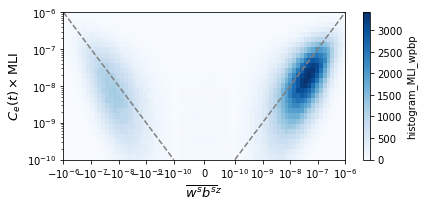

In [22]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((aMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/FIOCOM32-wb_medianCe-hist_01.pdf')

In [28]:
alpham = (Ce).mean(['yu_ocean','xu_ocean'],skipna=True)

amMLI = alpham*MLI
amMLI.name = 'MLI'

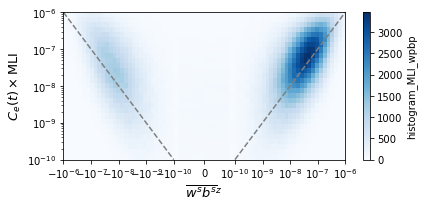

In [40]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((amMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/FIOCOM32-wb_meanCe-hist_01.pdf')

In [30]:
alpha75 = np.ones(len(MLI.time))
for i in range(len(MLI.time)):
    alpha75[i] = np.quantile(np.ma.masked_invalid((Ce).isel(time=i)).compressed(), 
                             .75
                            )

a75MLI = alpha75[:,np.newaxis,np.newaxis]*MLI
a75MLI.name = 'MLI'

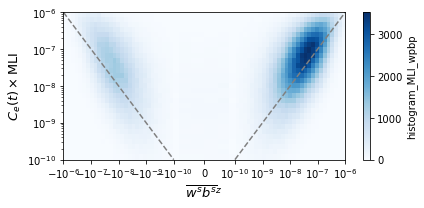

In [39]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((a75MLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/FIOCOM32-wb_075Ce-hist_01.pdf')

In [27]:
alphamo = np.ones(len(MLI.time))
for i in range(len(MLI.time)):
    histo = xhist(Ce.isel(time=i),
                  bins=[np.logspace(-4,2,100)
                       ]
                 )
    ix = np.argmax(histo.values)
    alphamo[i] = histo.Ce_bin[ix]

amoMLI = alphamo[:,np.newaxis,np.newaxis]*MLI
amoMLI.name = 'MLI'

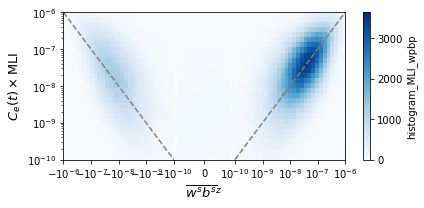

In [26]:
fig, ax = plt.subplots(figsize=(6,3))
fig.set_tight_layout(True)

xhist((amoMLI).chunk({'time':1}), 
      wpbp_coar.chunk({'time':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax, cmap='Blues')

ax.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax.set_xscale('symlog', linthresh=1e-10)
ax.set_yscale('log')
ax.set_ylim([1e-10,1e-6])
ax.set_xlim([-1e-6,1e-6])
ax.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax.set_ylabel(r"$C_e(t)\times$MLI", fontsize=13)

plt.savefig('/home/jovyan/Figures/FIOCOM32-wb_modeCe-hist_01.pdf')

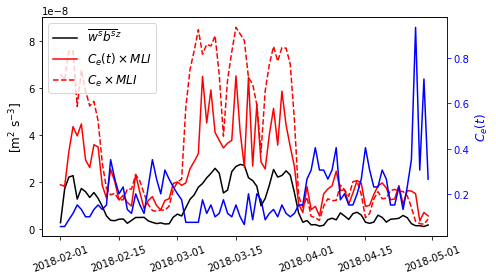

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:51668 remote=tcp://127.0.0.1:33833>


In [28]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['yu_ocean','xu_ocean'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, amoMLI.median(['yu_ocean','xu_ocean'],skipna=True), c='r', label=r'$C_e(t) \times MLI$')
ax.plot(time, (alphamo.mean()*MLI).median(['yu_ocean','xu_ocean'],skipna=True), c='r', ls='--', label=r'$C_e \times MLI$')

ax2.plot(time, alphamo, c='b')

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2018-02-01','2018-02-15','2018-03-01','2018-03-15','2018-04-01','2018-04-15','2018-05-01'])
ax.set_xticklabels(labels=['2018-02-01','2018-02-15','2018-03-01','2018-03-15','2018-04-01','2018-04-15','2018-05-01'],
                   rotation=20)
ax2.set_ylabel(r"$C_e(t)$", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='upper left', fontsize=12)
plt.savefig('/home/jovyan/Figures/FIOCOM32-wb_modeCe-timeseries_01.pdf')